# Part 3 Solutions

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## 3.1

In [12]:
from solutions.euler_black_scholes import EulerBlackScholes

# Automatically Orchestrate Multiple Runs

def run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, num_simulations):
    """Run multiple simulations with different hedging frequencies."""
    results = {}
    
    for interval in hedge_intervals:
        print(f"Running simulations with hedging every {interval} trading days...")
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating {interval}-day hedging"):
            # Change up the seec
            np.random.seed(200 + i)
            
            # Run SIM
            model = EulerBlackScholes(S0, r, sigma, T, N)
            sim_result = model.delta_hedge_short_call(K, interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[interval] = {
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

In [13]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Define hedging intervals to test
hedge_intervals = [1, 5, 21]  # Daily, weekly, and monthly

# Number of simulations
num_simulations = 100

# Run simulations
results = run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, 
                                    num_simulations)

Running simulations with hedging every 1 trading days...


Simulating 1-day hedging: 100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


Running simulations with hedging every 5 trading days...


Simulating 5-day hedging: 100%|██████████| 100/100 [00:02<00:00, 48.04it/s]


Running simulations with hedging every 21 trading days...


Simulating 21-day hedging: 100%|██████████| 100/100 [00:00<00:00, 181.56it/s]


### Visualisations

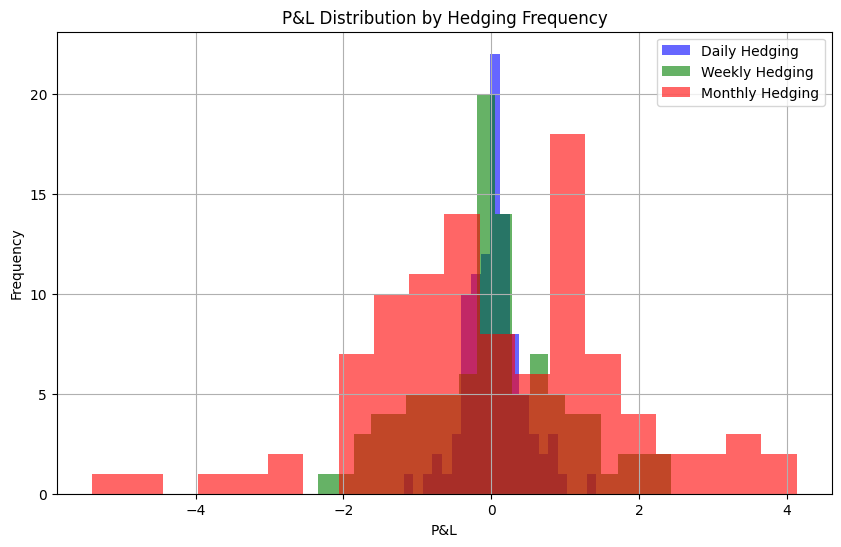

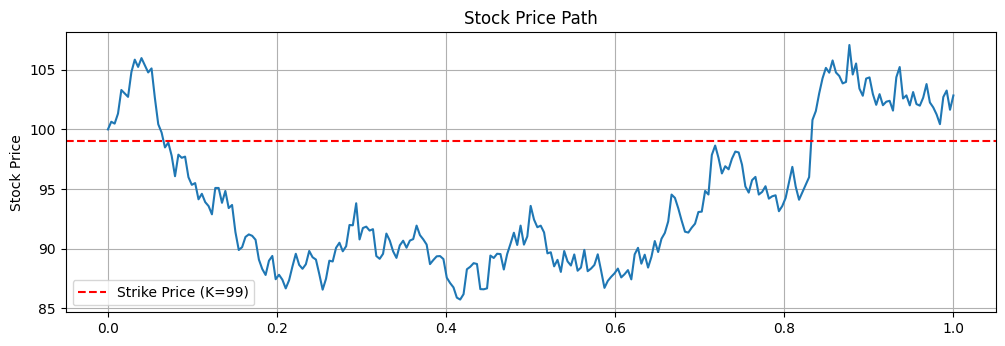

In [ ]:
# 1. P&L Distribution Comparison
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']  # Different colors for different frequencies

for i, interval in enumerate(hedge_intervals):
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
        
    plt.hist(results[interval]['all_pnl'], bins=20, alpha=0.6, 
                color=colors[i], label=f"{interval_desc} Hedging")

plt.title('P&L Distribution by Hedging Frequency')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

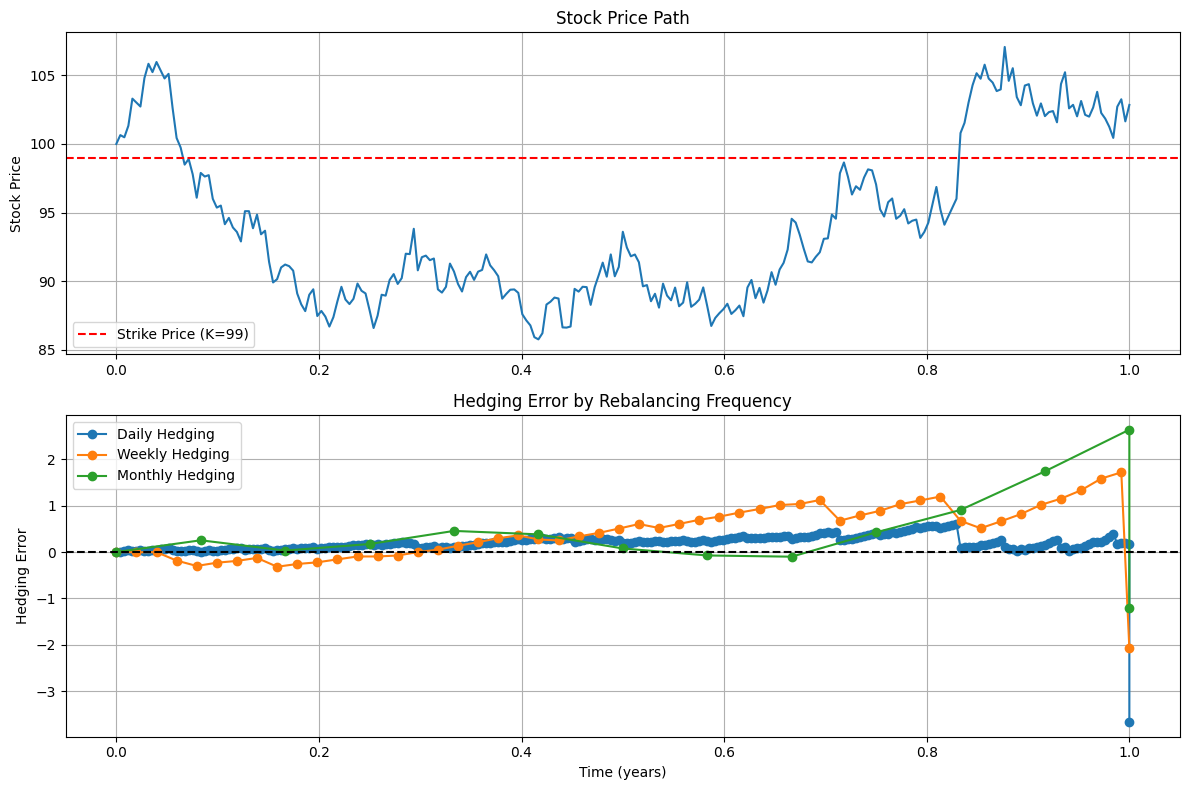

In [17]:
# 2. Single Simulation Analysis with Different Frequencies
plt.figure(figsize=(12, 8))

# Use same seed for all simulations to compare hedging frequency effect on same path
np.random.seed(42)

# Simulate stock path once
model = EulerBlackScholes(S0, r, sigma, T, N)
time, stock_path = model.simulate()

# Plot stock path
plt.subplot(2, 1, 1)
plt.plot(time, stock_path)
plt.axhline(y=K, color='r', linestyle='--', label=f'Strike Price (K={K})')
plt.title('Stock Price Path')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Plot hedging errors for different frequencies
plt.subplot(2, 1, 2)

for interval in hedge_intervals:
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
    
    # Set same seed to ensure same stock path
    np.random.seed(42)
    model = EulerBlackScholes(S0, r, sigma, T, N)
    sim = model.delta_hedge_short_call(K, interval)
    
    # Calculate hedging error (portfolio value + option value should ideally be 0)
    # Ensure both arrays have the same length by using the minimum length
    min_length = min(len(sim['portfolio_values']), len(sim['option_values']))
    hedging_error = sim['portfolio_values'][:min_length] - sim['option_values'][:min_length]
    plt.plot(sim['hedge_times'][:min_length], hedging_error, '-o', label=f"{interval_desc} Hedging")

plt.title('Hedging Error by Rebalancing Frequency')
plt.xlabel('Time (years)')
plt.ylabel('Hedging Error')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--')

plt.tight_layout()
plt.show()

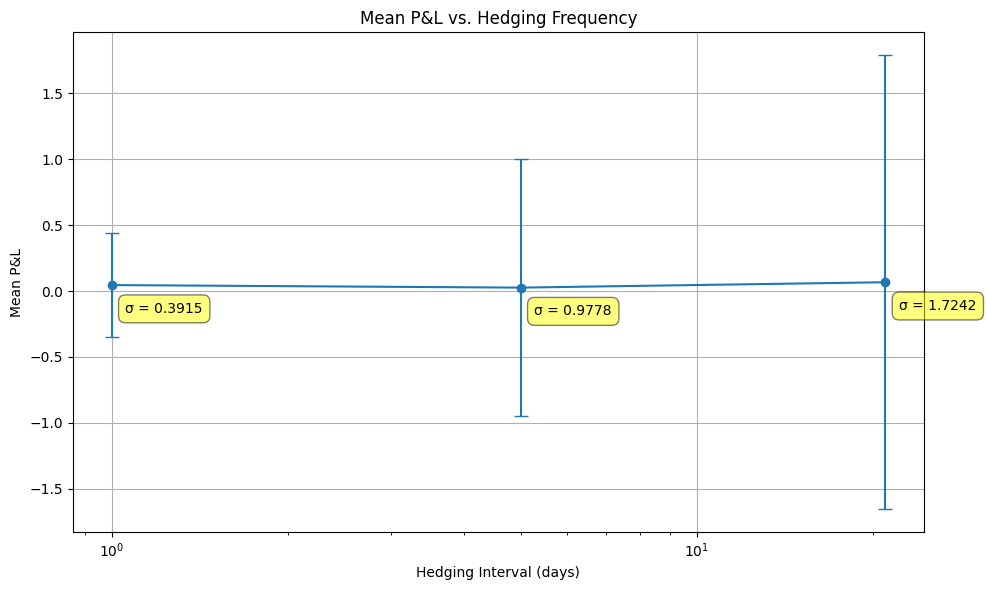

In [18]:
# 3. Scatter plot of P&L vs. Hedging Frequency
plt.figure(figsize=(10, 6))

mean_pnls = [results[interval]['mean_pnl'] for interval in hedge_intervals]
std_pnls = [results[interval]['std_pnl'] for interval in hedge_intervals]

plt.errorbar(hedge_intervals, mean_pnls, yerr=std_pnls, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Hedging Interval (days)')
plt.ylabel('Mean P&L')
plt.title('Mean P&L vs. Hedging Frequency')
plt.grid(True)

# Add text annotations with standard deviations
for i, interval in enumerate(hedge_intervals):
    plt.annotate(f'σ = {std_pnls[i]:.4f}', 
                (interval, mean_pnls[i]),
                xytext=(10, -20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.show()